<a href="https://colab.research.google.com/github/robingenz/htwg-machine-learning-exercises/blob/main/exercises/02_Linear_Regression/02_eigengesichter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eigengesichter

## Setup

### Einbinden von Paketen

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import math
%matplotlib inline

np.__version__, pd.__version__, sklearn.__version__

('1.23.4', '1.5.0', '1.1.3')

In [134]:
%load_ext version_information
%version_information

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.10.8 64bit [GCC 10.2.1 20210110]
IPython 8.6.0
OS Linux 5.10.104 linuxkit aarch64 with glibc2.31
Mon Nov 14 09:51:49 2022 UTC

## Aufgaben

### Aufgabe a)

In [135]:
import os
from urllib.request import urlretrieve
import tarfile

tgz_file_path = 'data/lfw-funneled.tgz'
data_dir_path = 'data/lfw_funneled'

# Herunterladen des Datensatzes
if not os.path.isfile(tgz_file_path):
    print("Downloading...")
    urlretrieve('http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz', filename = tgz_file_path)
    print("Download finished.")

dateDownloaded = !date #Calling Linux
print(dateDownloaded)

# Entpacken des Datensatzes
if not os.path.isdir(data_dir_path):
    print("Extracting...")
    tar = tarfile.open(tgz_file_path, 'r:gz')
    tar.extractall(path='data/')
    tar.close()
    print("Extract finished.")

['Mon Nov 14 09:51:49 UTC 2022']


Finden von Personen mit **70 oder mehr** Bildern:

In [136]:
person_dir_paths = []
for subdir, _, files in os.walk(data_dir_path):
    if len(files) >= 70:
        person_dir_paths.append(subdir)

print('Found', len(person_dir_paths), 'persons with ≥ 70 images.')

Found 7 persons with ≥ 70 images.


### Aufgabe b)

Datensatz in Trainings- und Testbilder aufteilen.

In [137]:
from os import listdir

test_image_paths = []
training_image_paths = []

for person_dir_path in person_dir_paths:
    files = sorted(listdir(person_dir_path))
    test_image_paths.append(f'{person_dir_path}/{files[0]}')
    for i in range(1, len(files)):
        training_image_paths.append(f'{person_dir_path}/{files[i]}')

print('Splitted into', len(test_image_paths), 'test images and', len(training_image_paths), 'training images.')

Splitted into 7 test images and 1281 training images.


Vorverarbeitung der Bilder:

In [138]:
from skimage import io, util, transform

def show_image(image):
    io.imshow(image) 
    io.show()

def load_image_from_path(path, as_gray=True):
    image = io.imread(path, as_gray=as_gray)
    return image

def transform_image(image):
    image = util.crop(image, ((100,70), (80,80))) # Values are based on first image of Hugo_Chavez
    image = transform.resize(image, (32,32))
    # show_image(image)
    image = np.hstack(image)
    return image

def create_image_stack(image):
    stack = np.hstack(image)
    return stack

training_images = []
training_stacks = []
for training_image_path in training_image_paths:
    image = load_image_from_path(training_image_path)
    training_images.append(image)
    image = transform_image(image)
    stack = create_image_stack(image)
    training_stacks.append(stack)
training_matrix = np.asarray(training_stacks)

test_images = []
test_stacks = []
for test_image_path in test_image_paths:
    image = load_image_from_path(test_image_path)
    test_images.append(image)
    image = transform_image(image)
    stack = create_image_stack(image)
    test_stacks.append(stack)
test_matrix = np.asarray(test_stacks)

### Aufgabe c)

Anwendung der **Hauptkomponentenanalyse** aus Aufgabenblatt 1:

In [139]:
from scipy import stats

def transform(dataFrame: pd.DataFrame):
    dataFrame = dataFrame.copy()
    # Zentrierung
    for col in dataFrame.columns:
        dataFrame[col] = dataFrame[col] - dataFrame[col].mean()
    # Normierung
    return dataFrame.apply(stats.zscore)

def pca(dataFrame: pd.DataFrame):
    # 1. - 2. Zentrierung und Normierung
    dataFrame = transform(dataFrame)
    # 3. Erstellen einer Daten- und Designmatrix
    X = dataFrame.to_numpy()
    # 4. - 7. Berechnung der Singulärwertzerlegung
    U, D, V = np.linalg.svd(X, full_matrices=False)
    # U: Unitäre Matrix mit linken singulären Vektoren als Spalten der Form (M,K)
    # D (Sigma): Enthält die singulären Vektoren
    # V: Unitäre Matrix mit rechten singulären Vektoren als Reihen der Form (K,N)
    return U, D, V

training_U, training_D, training_V = pca(pd.DataFrame(training_matrix))

training_n = training_U.shape[0]

training_pca_df = pd.DataFrame(training_D, columns=['Singular Value'])
training_pca_df['Eigenvalue'] = training_pca_df['Singular Value'] ** 2
training_pca_df['Varianz'] = training_pca_df['Singular Value'] / (training_n - 1)
training_pca_df['Explained Variance (%)'] = (training_pca_df['Varianz'] / (training_pca_df['Varianz'].sum())) * 100
training_pca_df['Cumulative Explained Variance (%)'] = training_pca_df['Explained Variance (%)'].cumsum()
training_pca_df['Error (%)'] = round(100 - training_pca_df['Cumulative Explained Variance (%)'], 3)
training_pca_df

,Singular Value,Eigenvalue,Varianz,Explained Variance (%),Cumulative Explained Variance (%),Error (%)
0,613.115765,375910.940903,0.478997,4.493459,4.493459,95.507
1,459.986970,211588.012833,0.359365,3.371195,7.864654,92.135
2,259.326519,67250.243456,0.202599,1.900576,9.765231,90.235
3,219.544265,48199.684325,0.171519,1.609016,11.374247,88.626
4,213.844273,45729.372896,0.167066,1.567242,12.941488,87.059
...,...,...,...,...,...,...
1019,0.247811,0.061410,0.000194,0.001816,99.993332,0.007
1020,0.239860,0.057533,0.000187,0.001758,99.995090,0.005
1021,0.233798,0.054661,0.000183,0.001713,99.996803,0.003
1022,0.220105,0.048446,0.000172,0.001613,99.998417,0.002


Darstellung der ersten 150 **Eigenwerte** als Diagramm:

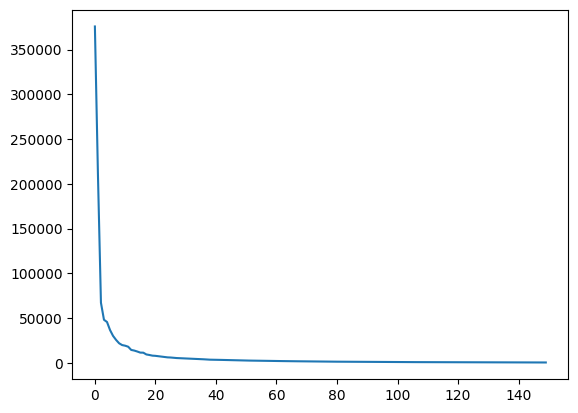

In [140]:
training_pca_df['Eigenvalue'].head(150).plot()
plt.show() 

Darstellung der ersten 12 **Eigengesichter** (mit PCA aus Aufgabenblatt 1):

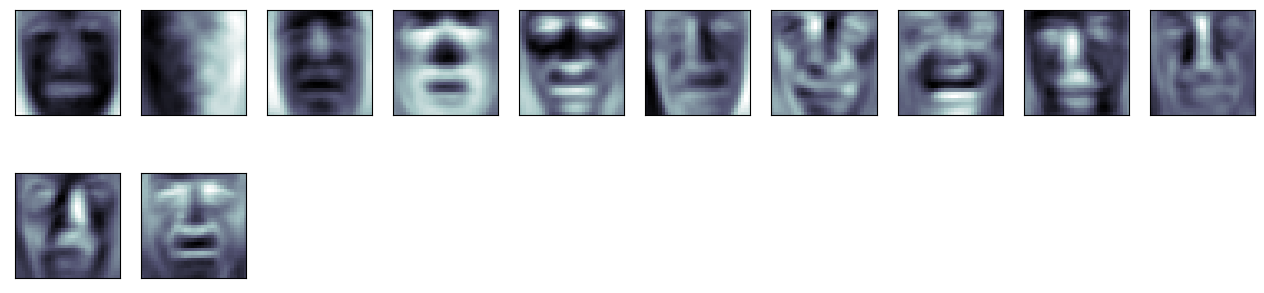

In [141]:
figure = plt.figure(figsize=(16, 6))
for i in range(12):
    ax = figure.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(training_V[i].reshape(32, 32), cmap=plt.cm.bone)

<!-- 1. Helligkeit der Gesichter
2. Beleuchtung wandert -->

Darstellung der ersten 12 **Eigengesichter** (mit PCA aus `sklearn`):

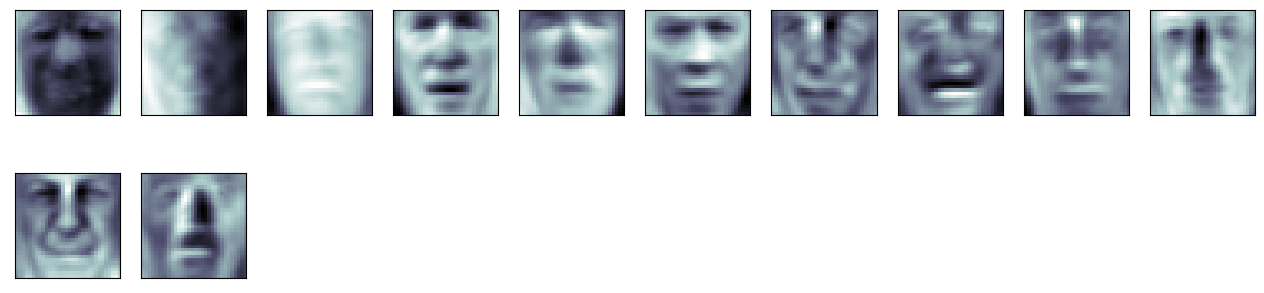

In [142]:
# See: https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html
from sklearn import decomposition

sklearn_pca_result = decomposition.PCA(n_components=150, whiten=True)
sklearn_pca_result.fit(training_matrix)

figure = plt.figure(figsize=(16, 6))
for i in range(12):
    axes = figure.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    axes.imshow(sklearn_pca_result.components_[i].reshape(32, 32), cmap=plt.cm.bone)

### Aufgabe d)

**Projektion** der Trainings- und Testbilder auf die ersten 7 Eigengesichter:

In [151]:
# See https://towardsdatascience.com/pca-and-svd-explained-with-numpy-5d13b0d2a4d8
transformed_test_matrix = transform(pd.DataFrame(test_matrix))
test_projections = np.dot(transformed_test_matrix, np.diag(training_D))[:,[0,1,2,3,4,5,6]]
training_projections = np.dot(training_U, np.diag(training_D))[:,[0,1,2,3,4,5,6]]

Berechnung des **euklidischen Abstand** des Testbildes in diesem 7-dimensionalen Merkmalsraum zu allen Trainingsbildern:

In [153]:
min_distances = []
for test_projection in test_projections[:,[0,1,2,3,4,5,6]]:
    distances = []
    for train_projection in training_projections[:,[0,1,2,3,4,5,6]]:
        distance = math.dist(test_projection, train_projection)
        distances.append(distance)
    min_distances.append(np.argmin(distances))

Abbildung der 7 **Testbilder**:

data/lfw_funneled/Ariel_Sharon/Ariel_Sharon_0001.jpg
data/lfw_funneled/Colin_Powell/Colin_Powell_0001.jpg
data/lfw_funneled/Donald_Rumsfeld/Donald_Rumsfeld_0001.jpg
data/lfw_funneled/George_W_Bush/George_W_Bush_0001.jpg
data/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0001.jpg
data/lfw_funneled/Hugo_Chavez/Hugo_Chavez_0001.jpg
data/lfw_funneled/Tony_Blair/Tony_Blair_0001.jpg


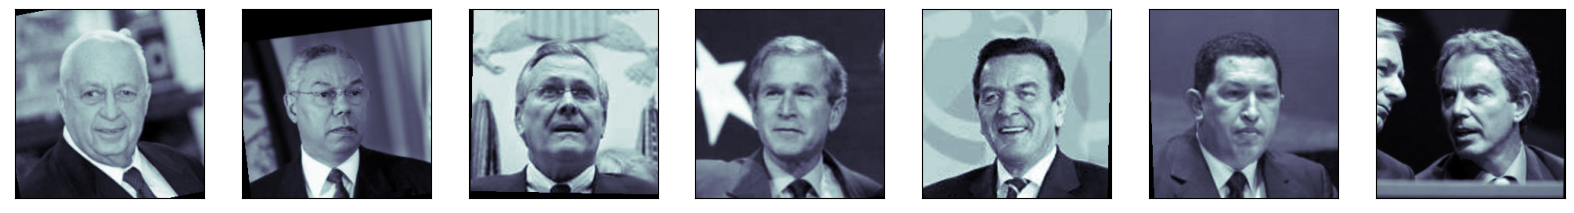

In [146]:
figure = plt.figure(figsize=(20, 6))
for i, test_image in enumerate(test_images):
    axes = figure.add_subplot(2, 7, i + 1, xticks=[], yticks=[])
    axes.imshow(test_image, cmap=plt.cm.bone)
    print(test_image_paths[i])
plt.show()

Abbildung der 7 **nächstgelegenen Trainingsbilder**:

data/lfw_funneled/George_W_Bush/George_W_Bush_0106.jpg
data/lfw_funneled/George_W_Bush/George_W_Bush_0106.jpg
data/lfw_funneled/Tony_Blair/Tony_Blair_0039.jpg
data/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0037.jpg
data/lfw_funneled/George_W_Bush/George_W_Bush_0106.jpg
data/lfw_funneled/George_W_Bush/George_W_Bush_0106.jpg
data/lfw_funneled/Gerhard_Schroeder/Gerhard_Schroeder_0037.jpg


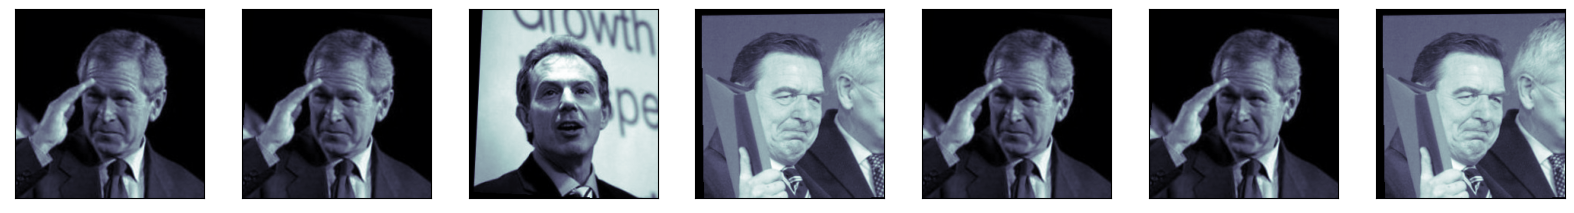

In [147]:
figure = plt.figure(figsize=(20, 6))
for i, test_image in enumerate(test_images):
    axes = figure.add_subplot(2, 7, i + 1, xticks=[], yticks=[])
    axes.imshow(training_images[min_distances[i]], cmap=plt.cm.bone)
    print(training_image_paths[min_distances[i]])
plt.show()

**Fazit:** Nur Bild 3 wurde korrekt klassifiziert!